In [1]:
%matplotlib inline

In [2]:

# Import Libraries
import gdal
import os
import json
import geopandas as gpd
import numpy as np


from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

from skimage import exposure
from skimage import feature
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from skimage.color import rgb2gray
from skimage import data

import math

In [3]:
# Import Folders
data_folder = os.path.abspath("data")
output_folder = os.path.abspath("output")
#check if outfolder exists if not create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

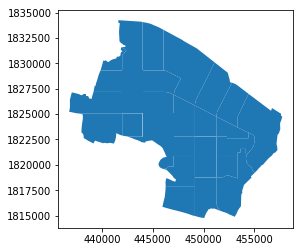

In [4]:
# Get Area of interest
aoiFilePath = os.path.join(data_folder, 'LPS_TOWNSHIP.shp')
aoiDf = gpd.read_file(aoiFilePath)
#aoiDf = aoiDf.to_crs(epsg =4326)
aoiDf.plot()


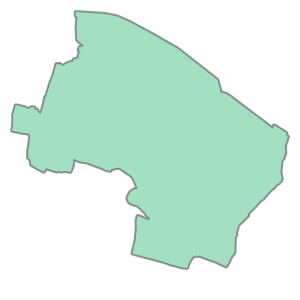

In [5]:
# Buffer
aoi_buf = aoiDf.unary_union.buffer(100)
aoi_buf

In [6]:
# Get Bounds For Amaravati Photo
bd = aoi_buf.bounds
aoi_bounds_for_gdal = [ bd[0], bd[3], bd[2], bd[1]]
aoi_bounds_for_gdal

[436655.7676270504, 1834338.8564980186, 457845.37661155075, 1814677.79786311]

In [7]:
# Get All scenes
satellite_data_folder = os.path.join(data_folder, 'sentinal_data')
files = os.listdir(satellite_data_folder )
scenes = [x for x in files if x.split('.')[-1] == 'zip']
print("Found", len(scenes), "Scenes")
scenes

Found 173 Scenes


['S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip',
 'S2A_MSIL1C_20151228T050222_N0201_R119_T44QMD_20151228T051117.zip',
 'S2A_MSIL1C_20160110T051202_N0201_R019_T44QMD_20160110T052202.zip',
 'S2A_MSIL1C_20160209T050942_N0201_R019_T44QMD_20160209T051853.zip',
 'S2A_MSIL1C_20160327T045632_N0201_R119_T44QMD_20160327T050917.zip',
 'S2A_MSIL1C_20160409T050632_N0201_R019_T44QMD_20160409T052229.zip',
 'S2A_MSIL1C_20160426T045652_N0201_R119_T44QMD_20160426T051146.zip',
 'S2A_MSIL1C_20160509T050702_N0202_R019_T44QMD_20160509T051501.zip',
 'S2A_MSIL1C_20160516T045702_N0202_R119_T44QMD_20160516T050657.zip',
 'S2A_MSIL1C_20160529T050702_N0202_R019_T44QMD_20160529T051501.zip',
 'S2A_MSIL1C_20160605T045702_N0202_R119_T44QMD_20160605T050656.zip',
 'S2A_MSIL1C_20160618T050652_N0204_R019_T44QMD_20160618T052334.zip',
 'S2A_MSIL1C_20160625T045702_N0204_R119_T44QMD_20160625T050623.zip',
 'S2A_MSIL1C_20160708T050702_N0204_R019_T44QMD_20160708T052335.zip',
 'S2A_MSIL1C_20160715T045702_N0204

In [8]:
# Process Imagery Now

In [167]:
def mask_cloud_interference(image, cc_p, cc_c = 2000):
    """Operator for Masking Cloud."""
    
    # cc_c = 2000 Hard Value to check if cloud coverage is wrong in metadata
    to_strech_hard = False
    
    cc_p = float(cc_p) # From Metadata
    
    for i in range(image.shape[np.argmin(image.shape)]):
        cc_v = np.percentile(image[:, :, i][~np.isnan(image[:, :, i])], (100-cc_p))
        print(cc_v, cc_c)
        #image[:, :, i][(image[:, :, i] > cc_v)] = cc_v
        if cc_v < cc_c:
            image[:, :, i][(image[:, :, i] > cc_v)] = cc_v
        else:
            to_strech_hard = True
            
    if to_strech_hard:
        print('Hard Streching image to values', cc_c)
        image[(image[:, :, ] > cc_c)] = cc_c
        
        
    return image

def linearStretch(image, pLow, pHigh):
    """Operator for linear stretching of histogram."""
    if len(image.shape) < 3:
        band = image
        iMin, iMax = np.percentile(band[~np.isnan(band)], (pLow, 100-pHigh))
        print(iMin, iMax)
        band_rescaled = exposure.rescale_intensity(band, in_range=(iMin, iMax))
        return band_rescaled
    else:
        tmp_image = []
        for i in range(image.shape[np.argmin(image.shape)]):
            band = image[:,:,i]
            iMin, iMax = np.percentile(band[~np.isnan(band)], (pLow, 100-pHigh))
            print(iMin, iMax)
            band_rescaled = exposure.rescale_intensity(band, in_range=(iMin, iMax))
            tmp_image.append(band_rescaled)
        img_rescale = np.dstack(tmp_image)

        return img_rescale

def std_stretch(image):
    """Operator for Standard Deviation stretching of histogram."""
    image[(image[:, :, ] > 2000)] = 2000
    tmp_image = []
    for i in range(image.shape[np.argmin(image.shape)]):
        band = image[:,:,i]
        #band[ band == 0 ] = np.nan
        #band[band > 2500] = 2500
        std_v = band.std()
        mean_v = band.mean()
        min_v = band.min()
        max_v = band.max()
        #factor = 1 + max(0, ((max_v - min_v)/(std_v + mean_v)))
        #factor = 2.3 + max(-2, (-2*((std_v/mean_v)**2)))
        #print('factor', factor)
        #print(band.var())
        '''if (max_v - min_v)/mean_v > 
        else:
            factor = 2'''
        factor = 2
        lo_v = max( min_v, mean_v - ( factor*std_v) )
        #lo_v = min_v
        hi_v = min( max_v, mean_v + ( factor*1.5*std_v) )
        if hi_v > 2000:
            hi_v = 2000
        print(std_v, mean_v, min_v, max_v, lo_v, hi_v)
        band = image[:,:,i]
        band_rescaled = exposure.rescale_intensity(band, in_range=(lo_v, hi_v))
        #mask = (band > lo_v) & (band < hi_v)
        #band_rescaled = exposure.equalize_hist(band, nbins=256, mask=mask)
        tmp_image.append(band_rescaled)
    img_rescale = np.dstack(tmp_image)

    return img_rescale

    
    

In [170]:
# Get All Images data to memory
img_store = []
print("\nProcessing Total", len(scenes), "scenes")
for idx, scene in enumerate(scenes):
    print("\n Reading", scene)  
    # Read scene
    infilepath = os.path.join(satellite_data_folder, scene)
    info = gdal.Info(infilepath, format='json')
    
    # Metadata
    metadata = info['metadata']
    l1c_name = metadata['SUBDATASETS']['SUBDATASET_1_NAME']
    cc_p = metadata['']['CLOUD_COVERAGE_ASSESSMENT']
    cc_p = float(cc_p)
    orbit_no = metadata['']['DATATAKE_1_SENSING_ORBIT_NUMBER']
    
    
    # check orbit no
    #if orbit_no in ['119'] and cc_p < 50: 
    if orbit_no in ['119']: 
    #if 1 == 1:
    
        #print(infilepath)

        raster_dataset = gdal.Open(l1c_name)
        raster_dataset = gdal.Translate('', raster_dataset, format = 'MEM', projWin = aoi_bounds_for_gdal, outputType = gdal.GDT_UInt16)
        geo_transform = raster_dataset.GetGeoTransform()
        proj = raster_dataset.GetProjectionRef()
        n_bands = raster_dataset.RasterCount    
        metadata = raster_dataset.GetMetadata()

        # Get Bands
        bands_data = []
        #bands_cc_v = []
        for b in range(1, n_bands+1):
            band = raster_dataset.GetRasterBand(b)
            band_name = band.GetMetadata_Dict()['BANDNAME']
            #print("Reading Band", band_name)
            #cc_v = np.percentile(band[:, i][~np.isnan(band[:, i])], (100-cc_p))
            bands_data.append(band.ReadAsArray().astype(float))
            #bands_cc_v.append(cc_v)
            band = None
        bands_data = np.dstack(b for b in bands_data)

        # Convert Image to RGB
        """
        red_band = bands_data[:, :, 0]                
        green_band = bands_data[:, :, 1]                  
        blue_band = bands_data[:, :, 2]        
        """

        # Cloud Coverage          
        
        
        image = np.dstack([bands_data[:, :, 0], bands_data[:, :, 1], bands_data[:, :, 2]])
        bands_data = None
        #image = exposure.rescale_intensity(image, out_range='uint8')
        #image = linearStretch(image, 0.1, cc_p)
        #image = exposure.adjust_gamma(image, gamma=0.95)
        #image = exposure.equalize_hist(image)
        #image = exposure.equalize_adapthist(image)
        #image = exposure.adjust_sigmoid(image)
    
        #mask_cloud_interference(image, (cc_p/1.2), cc_c = 2000)        
        #linearStretch(image, 0.1, cc_p)
        image = std_stretch(image)
        #image = linearStretch(image, 0.1, 0.1)
        #image = exposure.rescale_intensity(image, out_range='uint8')

        rgb_img = image
        image = None

        r = {
            'date': metadata['PRODUCT_START_TIME'].split('T')[0],
            'orbit_no': orbit_no,
            'cloud_coverage': cc_p,
            'img': rgb_img
        }
        rgb_img = None

        img_store.append(r)
        r = None
        print("Progress: ", idx+1, "/", len(scenes), "Scenes")

#Done
print("\nProcessed Total", len(scenes), "scenes")


Processing Total 173 scenes

 Reading S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip


c:\users\sandyjones\envs\geo\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


343.5796880613848 1068.0230096155647 549.0 2000.0 549.0 2000.0
262.2147790700589 1250.6291624919527 833.0 2000.0 833.0 2000.0
213.0805018666088 1415.8004644314362 1082.0 2000.0 1082.0 2000.0
Progress:  1 / 173 Scenes

 Reading S2A_MSIL1C_20151228T050222_N0201_R119_T44QMD_20151228T051117.zip
262.4705694458494 1042.8051209878938 495.0 2000.0 517.8639820961951 1830.216829325442
138.84985493308608 1121.3845736174715 772.0 2000.0 843.6848637512993 1537.9341384167296
100.83364296865071 1273.9723448698664 1024.0 2000.0 1072.305058932565 1576.4732737758186
Progress:  2 / 173 Scenes

 Reading S2A_MSIL1C_20160110T051202_N0201_R019_T44QMD_20160110T052202.zip

 Reading S2A_MSIL1C_20160209T050942_N0201_R019_T44QMD_20160209T051853.zip

 Reading S2A_MSIL1C_20160327T045632_N0201_R119_T44QMD_20160327T050917.zip
279.9433010099721 1412.4692502605646 706.0 2000.0 852.5826482406204 2000.0
174.04773455785772 1346.7363449044324 937.0 2000.0 998.6408757887169 1868.8795485780056
134.73406749037298 1468.3200323

63.01273526275653 1532.9417528374054 1340.0 2000.0 1406.9162823118922 1721.979958625675
Progress:  34 / 173 Scenes

 Reading S2A_MSIL1C_20170501T045701_N0205_R119_T44QMD_20170501T051026.zip
127.85016310473878 1925.6467983083826 1182.0 2000.0 1669.946472098905 2000.0
144.66253428377973 1910.7027482780654 1342.0 2000.0 1621.377679710506 2000.0
71.30450792115352 1963.6664679926855 1545.0 2000.0 1821.0574521503786 2000.0
Progress:  35 / 173 Scenes

 Reading S2A_MSIL1C_20170521T045701_N0205_R119_T44QMD_20170521T051027.zip
229.7441218842722 1560.949068808729 841.0 2000.0 1101.4608250401845 2000.0
131.6671595266854 1487.9957080659076 1099.0 2000.0 1224.6613890125368 1882.9971866459637
106.23591433397114 1597.785341124746 1303.0 2000.0 1385.313512456804 1916.4930841266596
Progress:  36 / 173 Scenes

 Reading S2A_MSIL1C_20170610T045701_N0205_R119_T44QMD_20170610T051036.zip
138.23286580964916 1934.8102909921713 1161.0 2000.0 1658.344559372873 2000.0
115.3462805550443 1941.117972738057 1337.0 200

155.0265690335359 1669.8646293262 1363.0 2000.0 1363.0 2000.0
Progress:  62 / 173 Scenes

 Reading S2A_MSIL1C_20180526T045701_N0206_R119_T44QMD_20180526T084531.zip
147.49529263446294 1901.3824442132582 1201.0 2000.0 1606.3918589443324 2000.0
125.74461565072397 1895.1424902915394 1350.0 2000.0 1643.6532589900914 2000.0
67.03628177019688 1962.2789368293552 1510.0 2000.0 1828.2063732889615 2000.0
Progress:  63 / 173 Scenes

 Reading S2A_MSIL1C_20180605T045701_N0206_R119_T44QMD_20180605T075521.zip
221.558313198528 1515.7569997172316 903.0 2000.0 1072.6403733201755 2000.0
123.606269587475 1468.948657138317 1124.0 2000.0 1221.736117963367 1839.767465900742
91.46010897190901 1569.207647035949 1330.0 2000.0 1386.287429092131 1843.587973951676
Progress:  64 / 173 Scenes

 Reading S2A_MSIL1C_20180608T050651_N0206_R019_T44QMD_20180608T084904.zip

 Reading S2A_MSIL1C_20180615T045701_N0206_R119_T44QMD_20180615T080052.zip
214.55742111359757 1364.1906298053218 883.0 2000.0 935.0757875781267 2000.0
13

 Reading S2A_MSIL1C_20190210T045941_N0207_R119_T44QMD_20190210T083359.zip
219.8333130400816 1082.751850356485 664.0 2000.0 664.0 1742.2517894767298
124.69367939145872 1232.5946769935529 958.0 2000.0 983.2073182106354 1606.675715167929
92.71455876179974 1399.1824876126814 1208.0 2000.0 1213.753370089082 1677.3261638980807
Progress:  91 / 173 Scenes

 Reading S2A_MSIL1C_20190220T045831_N0207_R119_T44QMD_20190220T075342.zip
451.8662818165446 1368.3935857189012 556.0 2000.0 556.0 2000.0
359.72665738446483 1471.4331320028978 824.0 2000.0 824.0 2000.0
282.2583065918144 1597.8936582113004 1111.0 2000.0 1111.0 2000.0
Progress:  92 / 173 Scenes

 Reading S2A_MSIL1C_20190302T045721_N0207_R119_T44QMD_20190302T083909.zip
432.0268380906306 1502.834666201307 594.0 2000.0 638.7809900200459 2000.0
338.90816879933897 1604.280278898903 929.0 2000.0 929.0 2000.0
244.7591359383023 1737.0082528515677 1202.0 2000.0 1247.4899809749631 2000.0
Progress:  93 / 173 Scenes

 Reading S2A_MSIL1C_20190305T050701_N02

65.40071367929843 1532.5355435993772 1367.0 2000.0 1401.7341162407804 1728.7376846372724
Progress:  121 / 173 Scenes

 Reading S2B_MSIL1C_20180315T050649_N0206_R019_T44QMD_20180315T084918.zip

 Reading S2B_MSIL1C_20180322T045649_N0206_R119_T44QMD_20180322T084331.zip
208.29477825527064 1445.7491218097944 942.0 2000.0 1029.159565299253 2000.0
120.170898345163 1477.7713983399722 1245.0 2000.0 1245.0 1838.2840933754612
92.05478525751806 1667.32391452234 1473.0 2000.0 1483.2143440073037 1943.4882702948942
Progress:  123 / 173 Scenes

 Reading S2B_MSIL1C_20180401T045649_N0206_R119_T44QMD_20180401T075939.zip
336.21814293379725 1637.076597101168 742.0 2000.0 964.6403112335736 2000.0
264.6581686891825 1638.005201929738 1033.0 2000.0 1108.688864551373 2000.0
200.29680718826663 1748.9710932957973 1247.0 2000.0 1348.3774789192641 2000.0
Progress:  124 / 173 Scenes

 Reading S2B_MSIL1C_20180411T045659_N0206_R119_T44QMD_20180411T084255.zip
363.91755548890393 1334.6408556119438 502.0 2000.0 606.80574

133.63987971667154 1214.9466508751657 960.0 2000.0 960.0 1615.8662900251802
Progress:  154 / 173 Scenes

 Reading S2B_MSIL1C_20181107T050009_N0207_R119_T44QMD_20181107T102253.zip
353.45747675580856 1042.9274919982313 459.0 2000.0 459.0 2000.0
245.4822547069732 1194.7363312220923 757.0 2000.0 757.0 1931.183095343012
204.52236817284876 1317.2067322394823 1010.0 2000.0 1010.0 1930.7738367580287
Progress:  155 / 173 Scenes

 Reading S2B_MSIL1C_20181117T050059_N0207_R119_T44QMD_20181117T075819.zip
542.9230615381333 1382.9928246927354 366.0 2000.0 366.0 2000.0
438.58122204098487 1496.621592797232 613.0 2000.0 619.4591487152624 2000.0
349.7493673285901 1603.585388604867 903.0 2000.0 904.0866539476867 2000.0
Progress:  156 / 173 Scenes

 Reading S2B_MSIL1C_20181127T050129_N0207_R119_T44QMD_20181127T073455.zip
268.7687222685332 1122.2302445010193 622.0 2000.0 622.0 1928.536411306619
164.12142645650655 1246.4500032885626 883.0 2000.0 918.2071503755494 1738.8142826580822
128.2468269545508 1400.68

In [ ]:
# Show Imagery


# Plotting 
plt.rcParams.update({'figure.max_open_warning': 0})
cols = 2
rows = math.ceil(len(img_store)/cols) + 1
size = 8
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*size, rows*size))
plt.subplots_adjust(right=1, top=1)
[axi.set_axis_off() for axi in ax.ravel()]

for i, x in enumerate(img_store):
    r = math.floor(i/cols)
    c = i - (r*cols)
    title = f"Date: {x['date']} \n Orbit No: {x['orbit_no']} \n Cloud Coverage: {x['cloud_coverage']}"
    ax[r][c].set_title(title)
    ax[r][c].imshow(x['img'])
    ax[r][c].axis('off')
    

In [ ]:
# Saving Imagery
for i, x in enumerate(img_store):
    title = f"Date: {x['date']} \n"
    outfile = os.path.join(output_folder, (x['date']+".png"))
    plt.figure(figsize=(12, 12))
    plt.imshow(x['img'])
    plt.title(title)
    plt.axis('off')
    plt.savefig(outfile)
    print(f"Saving {i+1} / {len(img_store)} File")

In [ ]:
#Animation

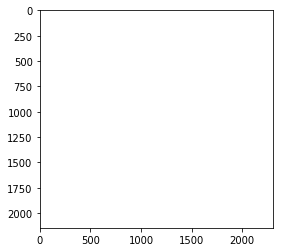

In [248]:
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
fig = plt.figure()
ims = []
for i, x in enumerate(img_store[0:2]):
    im = plt.imshow(x['img'])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()

In [ ]:
# Testing

0.0 159.0
0.0 130.0
0.0 124.0


Text(0.5, 1.0, 'histogram of gray values')

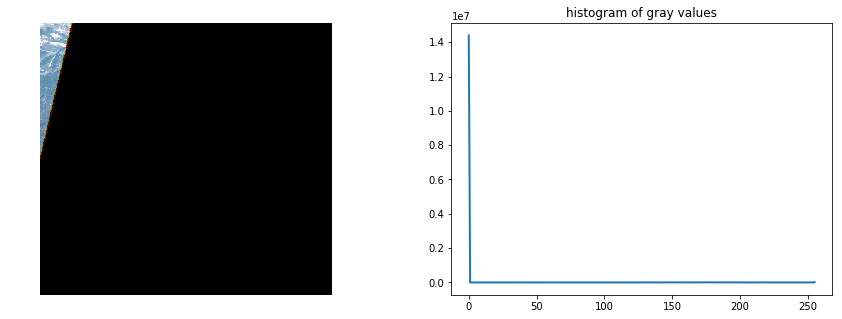

In [99]:
img = image.copy()
#img = exposure.rescale_intensity(img, out_range='uint8')
cc = 2000 #clip_cloud
#img[(img[:, :, 0] > cc) & (img[:, :, 1] > cc) & (img[:, :, 2] > cc)] = cc
for i in [0, 1 , 2]:
    img[(img[:, :, i] > cc)] = cc
img = linearStretch(img, 0.1, 0.1)
#p2, p98 = np.percentile(img, (2, 98))
#img = exposure.rescale_intensity(img, in_range=(p2, p98))#, out_range='uint8')
#img = exposure.equalize_hist(img)
#img = exposure.equalize_adapthist(img, clip_limit=0.03)
img = exposure.rescale_intensity(img, out_range='uint8')

hist, hist_centers = exposure.histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

In [110]:
img_store[0]

{'date': '2015-11-28', 'img': array([[[45, 33, 23],
         [49, 34, 23],
         [52, 35, 24],
         ...,
         [20, 16,  9],
         [20, 17, 10],
         [19, 17, 10]],
 
        [[47, 33, 22],
         [50, 34, 23],
         [51, 35, 25],
         ...,
         [21, 16, 10],
         [21, 17, 10],
         [20, 16, 10]],
 
        [[49, 34, 23],
         [54, 35, 25],
         [49, 35, 24],
         ...,
         [22, 16, 10],
         [22, 17, 10],
         [22, 16, 10]],
 
        ...,
 
        [[19, 18, 16],
         [24, 21, 20],
         [24, 19, 17],
         ...,
         [17, 14, 11],
         [16, 14, 11],
         [14, 14, 10]],
 
        [[25, 20, 19],
         [26, 21, 21],
         [23, 20, 18],
         ...,
         [15, 13, 10],
         [14, 15, 10],
         [13, 15, 11]],
 
        [[28, 23, 20],
         [32, 26, 23],
         [30, 25, 23],
         ...,
         [14, 15, 11],
         [13, 14, 10],
         [11, 12,  9]]], dtype=uint16)}

In [89]:
a = img_store[0]['img'][:, :, 0]

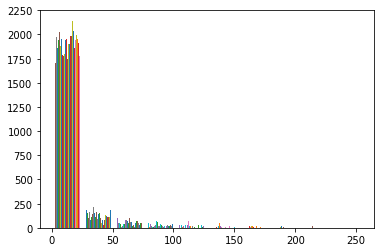

In [82]:
num, bins, _ = plt.hist(a)
plt.show()

In [111]:
metadata

{'CLOUD_COVERAGE_ASSESSMENT': '33.4667',
 'DATATAKE_1_DATATAKE_SENSING_START': '2016-05-29T05:07:02.027Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20160529T050702_004878_N02.02',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '19',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FORMAT_CORRECTNESS_FLAG': 'PASSED',
 'GENERAL_QUALITY_FLAG': 'PASSED',
 'GENERATION_TIME': '2016-05-29T05:15:01.000000Z',
 'GEOMETRIC_QUALITY_FLAG': 'PASSED',
 'PREVIEW_GEO_INFO': 'Not applicable',
 'PREVIEW_IMAGE_URL': 'Not applicable',
 'PROCESSING_BASELINE': '02.02',
 'PROCESSING_LEVEL': 'Level-1C',
 'PRODUCT_START_TIME': '2016-05-29T05:07:02.027Z',
 'PRODUCT_STOP_TIME': '2016-05-29T05:07:02.027Z',
 'PRODUCT_TYPE': 'S2MSI1C',
 'PRODUCT_URI': 'S2A_MSIL1C_20160529T050702_N0202_R019_T44QMD_20160529T051501.SAFE',
 'QUANTIFICATION_VALUE': '10000',
 'RADIOMETRIC_QUALITY_FLA